#### **Import Libraries**

In [58]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 

In [59]:
seed = 3
noise = True 
verbose = False 

In [60]:
np.random.seed(seed)

#### **Set Up Paths**

In [61]:
data_csv = './../../../toy-data/exp2/data_1.csv'

#### **Set Up Plotting**

In [62]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_14pt/Newsreader_14pt-ExtraLight.ttf


In [63]:
def fstage(race, gender, rent, health, fault):
    return 1.0-fault

#### Read in Data

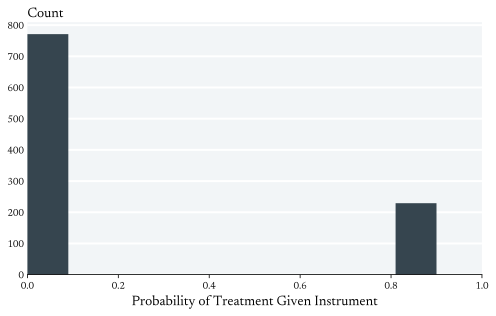

In [64]:
df = pd.read_csv(data_csv)
print(df[['Race', 'Gender', 'Rent', 'Health', 'Fault']].isnull().sum())
indices = np.random.choice(df.index, size=int(0.1 * len(df)), replace=False)
df = df.loc[indices].reset_index(drop=True)
  
df['FStage_Value'] = df.apply(lambda row: fstage(row['Race'], row['Gender'], row['Rent'], row['Health'], row['Fault']), axis=1)
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Generate Outcome Data**

In [65]:
# Assuming df already exists and has the correct 'Stage_Value' column
n = len(df)  # Get the number of rows in df

# Assign the 'Instrument' column
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=n)

# Calculate probability based on 'Stage_Value' and 'Instrument'
base_prob = 0.5  # This is an example base probability
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=n)
df['Outcome'] = df['Treatment'] + 0.1*np.random.normal(size=n)

In [66]:
import jax 
import jax.numpy as jnp 
import optax 
from trics.regression.data import Data 
from trics.regression.est import iv 

In [67]:
df.head()

,Race,Gender,Rent,Health,Fault,Description,FStage_Value,Instrument,Treatment,Outcome
0,0.0,1.0,777.482189,0.0,0.0,The tenant is a 45-year-old non-African Americ...,0.0,0,0,0.062634
1,0.0,1.0,1179.491995,0.0,0.0,The tenant is a 35-year-old single mother of t...,0.0,1,0,0.111294
2,1.0,0.0,1137.467211,0.0,0.0,The tenant is a 32-year-old African American m...,0.0,0,0,-0.069628
3,0.0,1.0,885.137481,1.0,0.0,The tenant is a 41-year-old Caucasian woman na...,0.0,1,0,0.177750
4,0.0,1.0,929.759809,1.0,0.0,The tenant is a 42-year-old non-African Americ...,0.0,1,0,0.074949


In [68]:
D = jnp.array(df['Treatment'].values.reshape(-1,1))
X = jnp.array(df['Fault'].values.reshape(-1,1))

Z = jnp.array(df['Instrument'].values.reshape(-1,1))
Y = jnp.array(df['Outcome'].values.reshape(-1,1))


regs = jnp.hstack((jnp.ones_like(X), X, Z))
Dhat_xz = regs @ np.linalg.lstsq(regs, D)[0]
 
regs = jnp.hstack((jnp.ones_like(X), X))
Dhat_x = np.array(regs @ np.linalg.lstsq(regs, D)[0])

residuals = Dhat_xz - Dhat_x
np.linalg.lstsq(np.hstack((residuals, np.ones_like(residuals))), Y)

/tmp/ipykernel_52384/771858664.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Dhat_xz = regs @ np.linalg.lstsq(regs, D)[0]
/tmp/ipykernel_52384/771858664.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Dhat_x = np.array(regs @ np.linalg.lstsq(regs, D)[0])
/tmp/ipykernel_52384/771858664.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rc

(array([[1.0855074 ],
        [0.15894337]], dtype=float32),
 array([136.81702], dtype=float32),
 2,
 array([31.622776,  2.148174], dtype=float32))

In [69]:
est = iv(Data(X, D, Y, Z))
df = pd.DataFrame({'Estimate': est})

In [70]:
# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/oracle_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)

In [71]:
est

Array([1.0855083], dtype=float32)